# 3 - Preprocessing

This code is mostly based on following references.
* References
    - https://github.com/joungh93/TAO_2022A/blob/main/Preprocess.ipynb
    - https://github.com/ysbach/SNU_AOclass/blob/master/Notebooks/07-Cosmic_Ray_Rejection.ipynb

* Useful manuals for preprocessing and more (based on IRAF)
    - http://astro.snu.ac.kr/~hhwang/Manuals.html

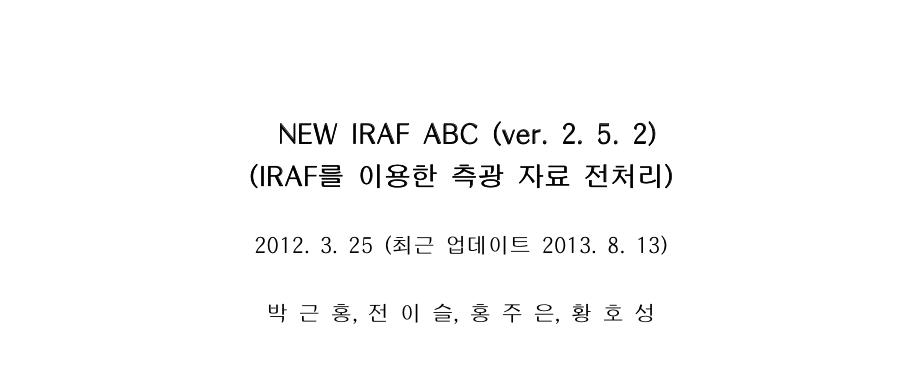

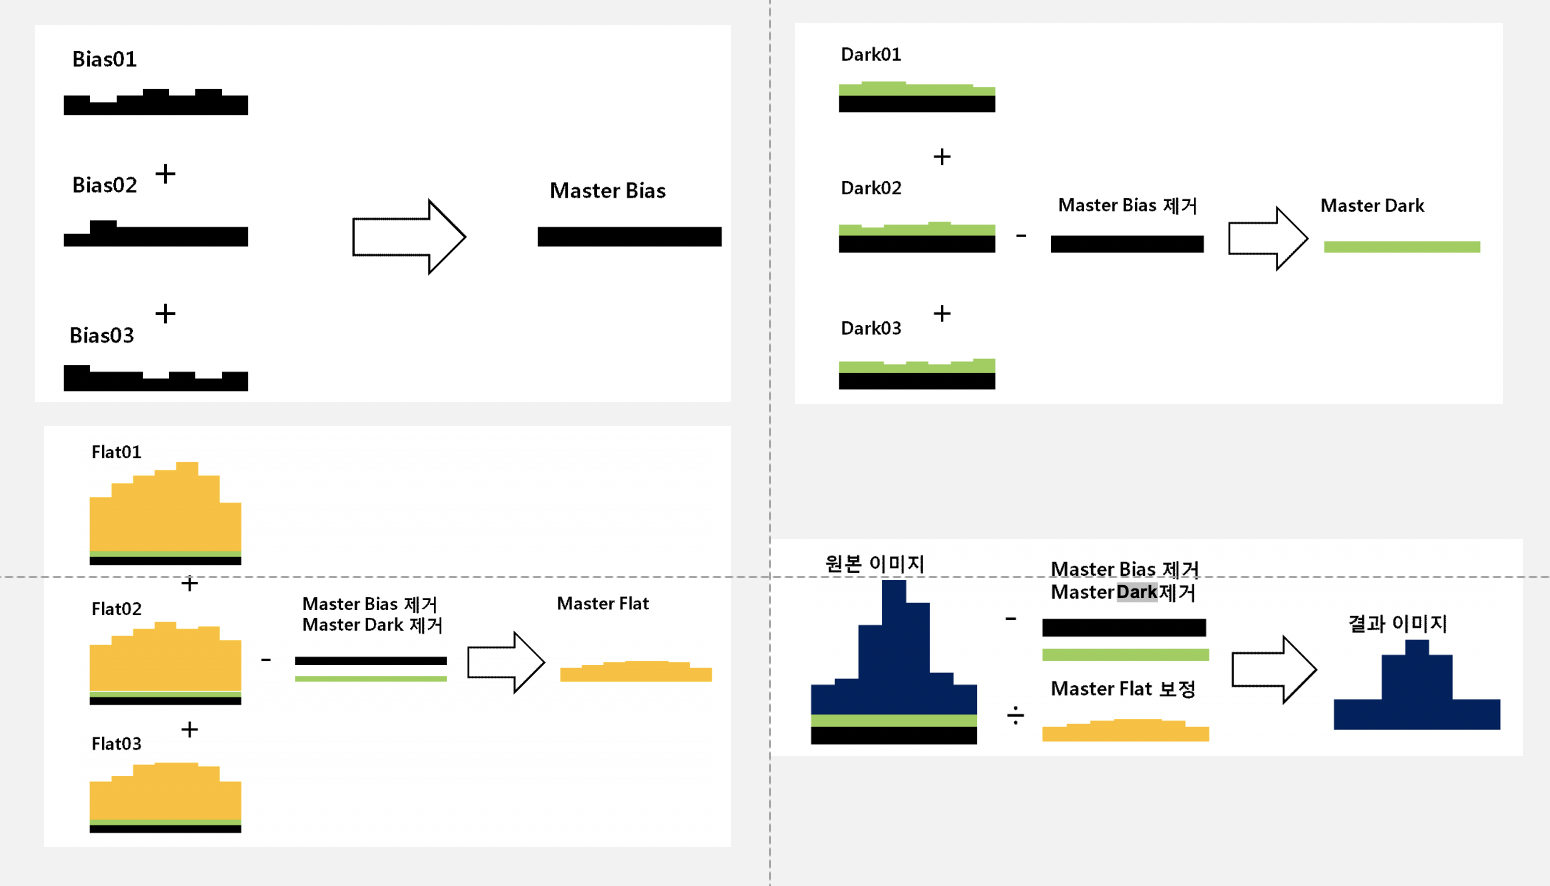

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from pathlib import Path
import time
import warnings

from astropy.io import fits
from astropy.visualization import ZScaleInterval
from astropy.nddata import CCDData
import astroscrappy
import astroalign as aa
from ccdproc import combine
from matplotlib import pyplot as plt
from matplotlib import rcParams


warnings.filterwarnings('ignore', append=True, category=UserWarning)

In [3]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

# 1. Preprocessing

***

# Object Setting

In [4]:
# setting object name
OBJNAME = 'A2255'

# setting locations
DATADIR = Path('../data')
OBJDIR = DATADIR / OBJNAME
RAWDIR = OBJDIR / 'raw'
OUTDIR = OBJDIR / 'reduced'

# making output directory if it doesn't exist
if not OUTDIR.exists():
    OUTDIR.mkdir()

# Inspecting data

In [5]:
# fetching path lists for each type of frames
bias_list = list(RAWDIR.glob('cal*bias.fit'))
dark_list_sci = list(RAWDIR.glob('cal*dk300.fit'))
dark_list_flat = list(RAWDIR.glob('cal*dk2.fit'))
flat_list_R = list(RAWDIR.glob('skyflat*R.fit'))
flat_list_I = list(RAWDIR.glob('skyflat*I.fit'))
sci_list_R  = list(RAWDIR.glob(OBJNAME + '*R.fit'))
sci_list_I  = list(RAWDIR.glob(OBJNAME + '*I.fit'))

# counting files
print(f"Bias: {len(bias_list):d} frames")
print(f"Dark: {len(dark_list_sci):d} frames")
print(f"Dark: {len(dark_list_flat):d} frames")
print(f"Flat (sky; R-band): {len(flat_list_R):d} frames")
print(f"Flat (sky; I-band): {len(flat_list_I):d} frames")
print(f"Science (object; R-band): {len(sci_list_R):d} frames")
print(f"Science (object; I-band): {len(sci_list_I):d} frames")

Bias: 9 frames
Dark: 9 frames
Dark: 9 frames
Flat (sky; R-band): 7 frames
Flat (sky; I-band): 7 frames
Science (object; R-band): 4 frames
Science (object; I-band): 4 frames


DATE-OBS = 2022-03-28T18:38:53
EXPTIME = 300.0
FILTER = R
INSTRUME = Moravian Instruments, C3-61000EC PRO


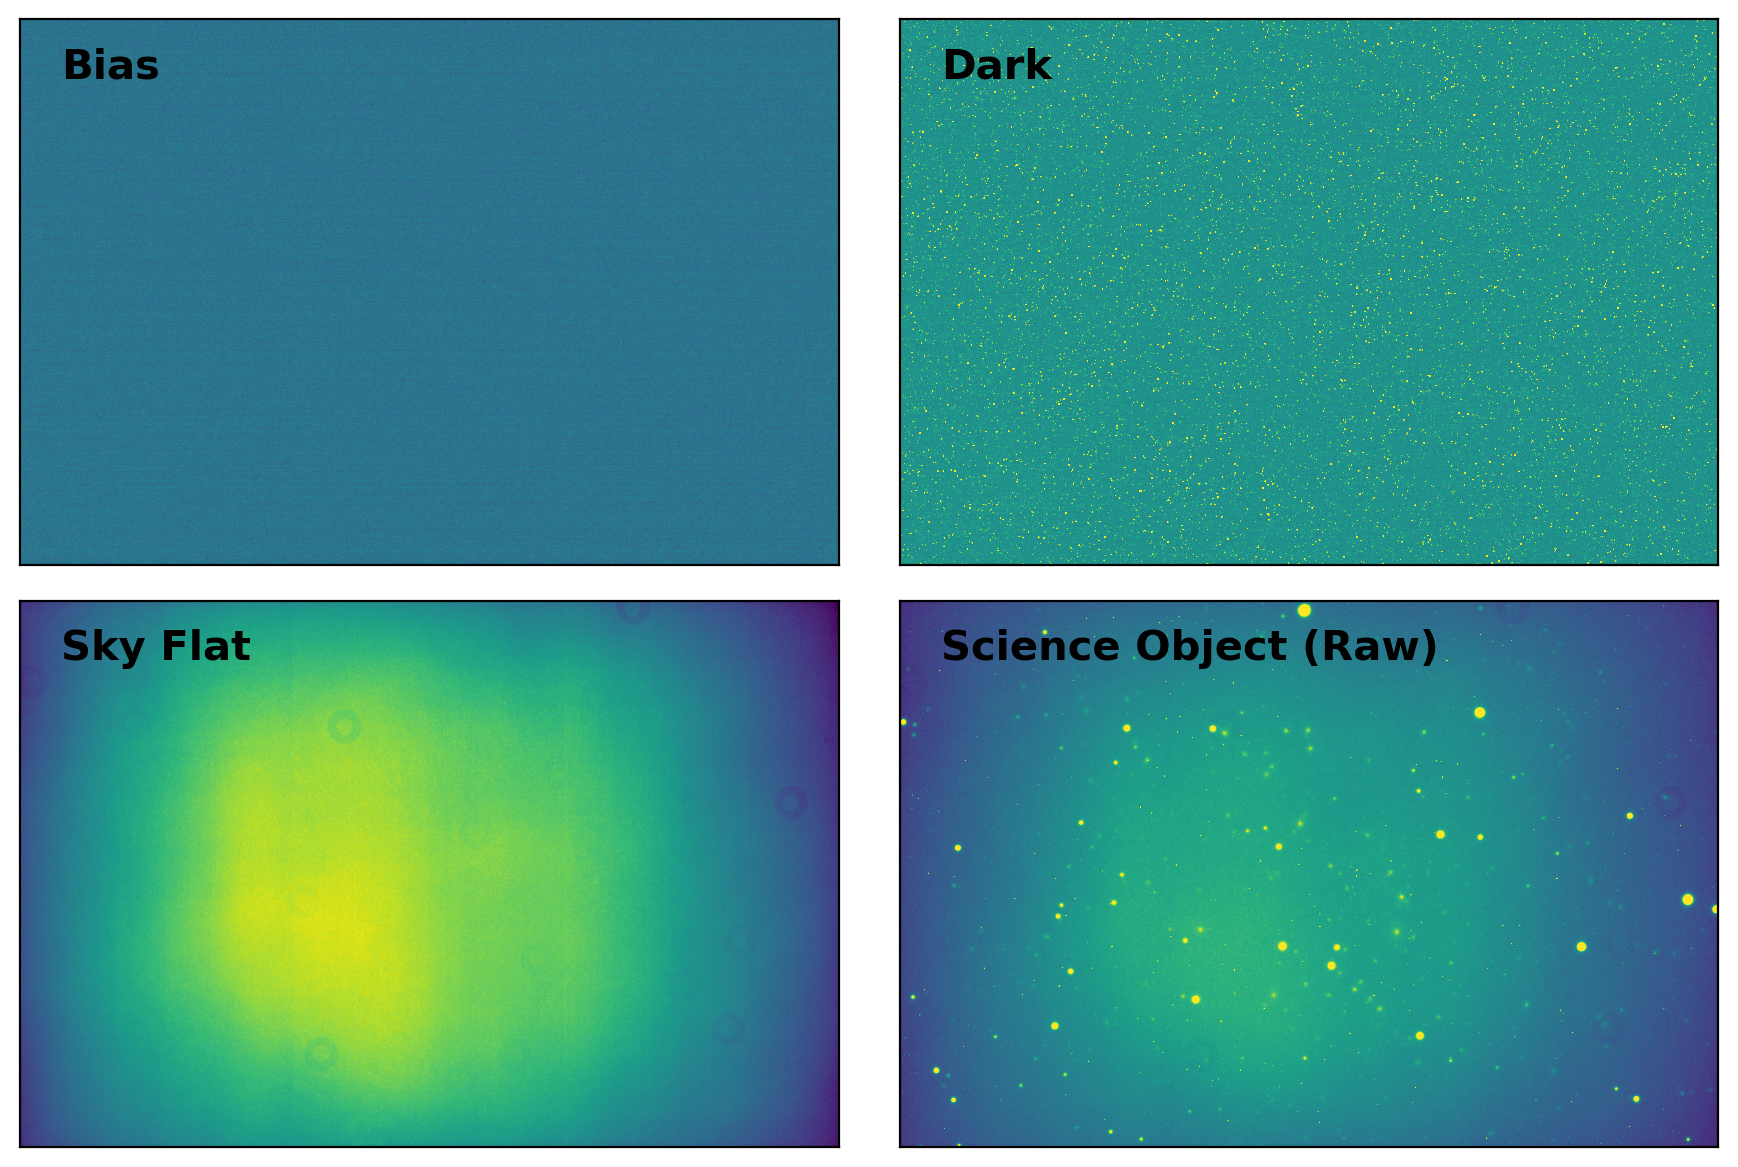

In [6]:
# test reading of science frame
fpath = sci_list_R[0]
data, hdr = fits.getdata(fpath, header=True)
# data - 2D image array of pixel values
# hdr  - image header information

gain = hdr['EGAIN'] # e-/ADU electronic gain

# key information of the image
for keys in ['DATE-OBS', 'EXPTIME', 'FILTER', 'INSTRUME']:
    print(keys+" = "+str(hdr[keys]))
    
# simple visualization using matplotlib pyplot
bias0 = fits.getdata(bias_list[0])
dark0 = fits.getdata(dark_list_sci[0])
flat0 = fits.getdata(flat_list_R[0])
sci0  = fits.getdata(sci_list_R[0])
label = ["Bias", "Dark", "Sky Flat", "Science Object (Raw)"]

# - for displaying in zscale
interval = ZScaleInterval()

# - plotting
fig, axs = plt.subplots(2, 2, figsize=(9,6))
for i, img0 in enumerate([bias0, dark0, flat0, sci0]):
    vmin, vmax = interval.get_limits(img0)
    ax = axs[i // 2][i % 2]
    ax.imshow(img0, origin='lower', vmin=vmin, vmax=vmax)
    ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
    ax.text(0.05, 0.95, label[i], fontsize=15.0, fontweight='bold',
            transform=ax.transAxes, ha='left', va='top')
plt.tight_layout()

# Deriving Readout Noise

In [7]:
# bring bias1 data
bias1, bias_hdr = fits.getdata(bias_list[0], header=True)            
bias1 = np.array(bias1).astype('float64')

# bring bias2 data
bias2 = fits.getdata(bias_list[0])            
bias2 = np.array(bias2).astype('float64')

# derive the differential image
dbias = bias2 - bias1

# bring gain 
gain = bias_hdr['EGAIN'] # e-/ADU electronic gain

#Calculate RN
RN = np.std(dbias)*gain / np.sqrt(2)
print('Readout Noise is {0:.2f}'.format(RN))

#Do it for all bias data
name = []
RN = []
for i in range(len(bias_list)-1):
    bias1 = fits.getdata(bias_list[i]).astype('float64')
    bias2 = fits.getdata(bias_list[i+1]).astype('float64')
    dbias = bias2 - bias1

    print(i,'st',np.std(dbias)*gain / np.sqrt(2))
    RN.append(np.std(dbias)*gain / np.sqrt(2))
print(np.mean(RN))    
rdnoise = np.mean(RN)

Readout Noise is 0.00
0 st 11.962726801272565
1 st 11.631764394386728
2 st 10.970984225242798
3 st 10.672470436767375
4 st 11.044990792885665
5 st 11.012366812449919
6 st 11.680534926138998
7 st 12.269772173451893
11.405701320324493


In [8]:
gain

7.0199995040893555

# Combining frames


Bias frame 1
  DATE-OBS = 2022-03-28T18:49:53
  EXPTIME = 0.0

Bias frame 2
  DATE-OBS = 2022-03-28T18:49:45
  EXPTIME = 0.0

Bias frame 3
  DATE-OBS = 2022-03-28T18:48:54
  EXPTIME = 0.0

Bias frame 4
  DATE-OBS = 2022-03-28T18:49:08
  EXPTIME = 0.0

Bias frame 5
  DATE-OBS = 2022-03-28T18:49:01
  EXPTIME = 0.0

Bias frame 6
  DATE-OBS = 2022-03-28T18:49:38
  EXPTIME = 0.0

Bias frame 7
  DATE-OBS = 2022-03-28T18:49:30
  EXPTIME = 0.0

Bias frame 8
  DATE-OBS = 2022-03-28T18:49:16
  EXPTIME = 0.0

Bias frame 9
  DATE-OBS = 2022-03-28T18:49:23
  EXPTIME = 0.0
bias_med fluctuation : 0.66
bias_sc fluctuation : 0.59


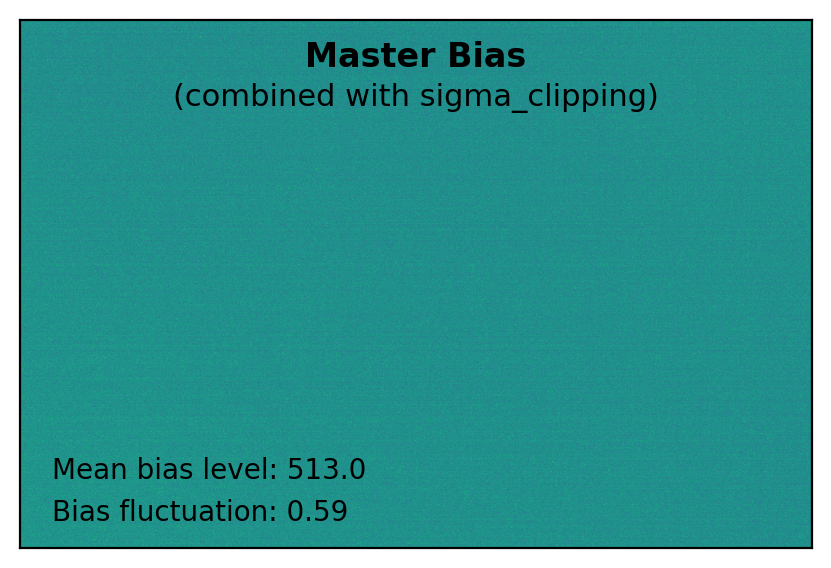

In [9]:
# creating a master bias
# - printing observation date & exposure time of all the bias frames
for i in np.arange(len(bias_list)):
    bias_hdr = fits.getheader(bias_list[i])
    print(f"\nBias frame {i+1:d}")
    for keys in ['DATE-OBS', 'EXPTIME']:
        print("  "+keys+" = "+str(bias_hdr[keys]))
        
# an example of the median combining bias frames
# - make empty array to successively attach each bias frame
bias_array = np.empty((len(bias_list), bias0.shape[0], bias0.shape[1]))

# - stacking the empty array with bias frames
for i in range(len(bias_list)):
    bias_data = fits.getdata(bias_list[i])
    bias_array[i, :, :] = bias_data
# bias_array[0, :, :]    # data from bias_list[0]
# bias_array[1, :, :]    # data from bias_list[1]

# - median combine
bias_med = np.median(bias_array, axis=0)
bias_stack = []

# combining bias frames with sigma clipping
# - stacking the empty array with bias frames
for i in range(len(bias_list)):
    bias_data, bias_hdr = fits.getdata(bias_list[i], header=True)
    bias = CCDData(data=bias_data, header=bias_hdr, unit='adu')
    bias_stack.append(bias)

# - combining
mbias = combine(bias_stack, sigma_clip=True,
                sigma_clip_high_thresh=3, sigma_clip_low_thresh=3)

# - save the master bias as fits file
bias_hdr['NFRAMES'] = len(bias_list)    # recording # of frames combined
fits.writeto(OUTDIR/"MBias.fits", mbias.data, bias_hdr, overwrite=True)

# - visualization of the combined master bias image
fig, ax = plt.subplots(1, 1, figsize=(5,3))
vmin, vmax = interval.get_limits(mbias)
ax.imshow(mbias, origin='lower', vmin=vmin, vmax=vmax)
ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
ax.text(0.50, 0.96, "Master Bias", fontsize=12.0, fontweight='bold',
        transform=ax.transAxes, ha='center', va='top')
ax.text(0.50, 0.88, "(combined with sigma_clipping)", fontsize=11.0,
        transform=ax.transAxes, ha='center', va='top')
ax.text(0.04, 0.12, f"Mean bias level: {np.mean(mbias):.1f}", fontsize=10.0,
        transform=ax.transAxes, ha='left', va='bottom')
ax.text(0.04, 0.04, f"Bias fluctuation: {np.std(mbias):.2f}", fontsize=10.0,
        transform=ax.transAxes, ha='left', va='bottom')
plt.tight_layout()

print(f'bias_med fluctuation : {np.std(bias_med):.2f}')
print(f'bias_sc fluctuation : {np.std(mbias):.2f}')

# Creating a master dark


<div class="alert alert-block alert-warning">

**Warning**: You should separate dark frames with different exposure times.
    
</div>


Dark frame 1
  DATE-OBS = 2022-03-28T19:45:24
  EXPTIME = 300.0

Dark frame 2
  DATE-OBS = 2022-03-28T19:40:17
  EXPTIME = 300.0

Dark frame 3
  DATE-OBS = 2022-03-28T19:14:40
  EXPTIME = 300.0

Dark frame 4
  DATE-OBS = 2022-03-28T19:30:02
  EXPTIME = 300.0

Dark frame 5
  DATE-OBS = 2022-03-28T19:35:09
  EXPTIME = 300.0

Dark frame 6
  DATE-OBS = 2022-03-28T19:24:55
  EXPTIME = 300.0

Dark frame 7
  DATE-OBS = 2022-03-28T19:19:48
  EXPTIME = 300.0

Dark frame 8
  DATE-OBS = 2022-03-28T19:55:38
  EXPTIME = 300.0

Dark frame 9
  DATE-OBS = 2022-03-28T19:50:31
  EXPTIME = 300.0

Dark frame 1
  DATE-OBS = 2022-03-28T18:50:00
  EXPTIME = 2.0

Dark frame 2
  DATE-OBS = 2022-03-28T18:50:19
  EXPTIME = 2.0

Dark frame 3
  DATE-OBS = 2022-03-28T18:51:00
  EXPTIME = 2.0

Dark frame 4
  DATE-OBS = 2022-03-28T18:51:20
  EXPTIME = 2.0

Dark frame 5
  DATE-OBS = 2022-03-28T18:50:40
  EXPTIME = 2.0

Dark frame 6
  DATE-OBS = 2022-03-28T18:50:10
  EXPTIME = 2.0

Dark frame 7
  DATE-OBS = 2022-03-28

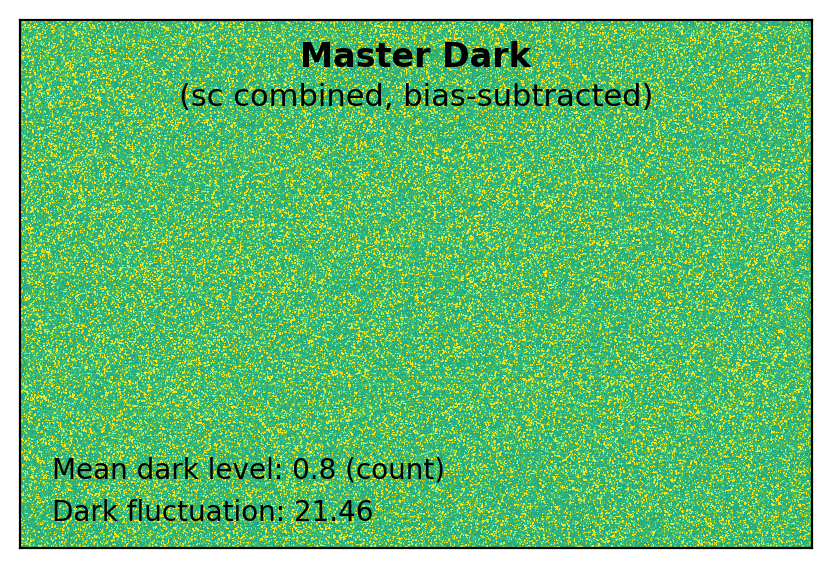

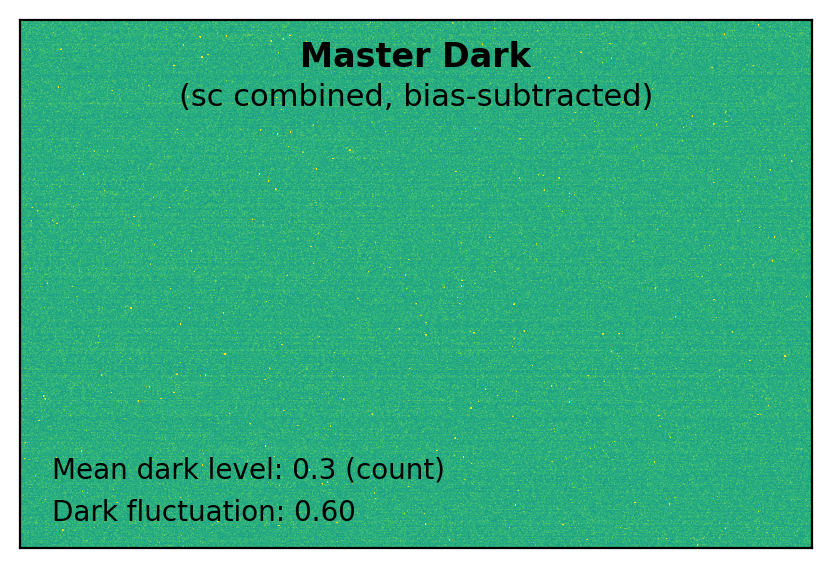

In [10]:
# - Note that the dark frames might have different exposure times.
def make_mdark(dark_list):
    # - checking the basic info
    # - Please check the consistancy in observation dates and exposure times. 
    for i in np.arange(len(dark_list)):
        dark_hdr = fits.getheader(dark_list[i])
        print(f"\nDark frame {i+1:d}")
        for keys in ['DATE-OBS', 'EXPTIME']:
            print("  "+keys+" = "+str(dark_hdr[keys]))
    
    # - stacking dark frames
    dark_stack = []
    for i in range(len(dark_list)):
        dark_data, dark_hdr = fits.getdata(dark_list[i], header=True)
        dark_bn = (dark_data - mbias.data)# / dark_hdr['EXPTIME']
        dark = CCDData(data=dark_bn, header=dark_hdr, unit='adu')    
        dark_stack.append(dark)
        
    # - combine with sigma clipping
    mdark = combine(dark_stack, sigma_clip=True,
                    sigma_clip_high_thresh=3, sigma_clip_low_thresh=3)
    
    # - correcting the negative values (physically impossible)
    mdark.data[mdark.data < 0.] = 0.
    
    # - save the master dark as fits file
    dark_hdr['NFRAMES'] = len(dark_list)    # recording # of dark frames combined
    fits.writeto(OUTDIR/f"MDark{dark_hdr['EXPTIME']:.0f}.fits",
                 mdark, dark_hdr, overwrite=True)
    
    # - visualization of the master dark
    fig, ax = plt.subplots(1, 1, figsize=(5,3))
    vmin, vmax = interval.get_limits(mdark)
    ax.imshow(mdark, origin='lower', vmin=-1, vmax=1)
    ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
    ax.text(0.50, 0.96, "Master Dark", fontsize=12.0, fontweight='bold',
            transform=ax.transAxes, ha='center', va='top')
    ax.text(0.50, 0.88, "(sc combined, bias-subtracted)", fontsize=11.0,
            transform=ax.transAxes, ha='center', va='top')
    ax.text(0.04, 0.12, f"Mean dark level: {np.mean(mdark):.1f} (count)",
            fontsize=10.0, transform=ax.transAxes, ha='left', va='bottom')
    ax.text(0.04, 0.04, f"Dark fluctuation: {np.std(mdark):.2f}", fontsize=10.0,
            transform=ax.transAxes, ha='left', va='bottom')
    plt.tight_layout()
    
    return mdark

mdark_sci, mdark_flat = make_mdark(dark_list_sci), make_mdark(dark_list_flat)

# Creating a master flat


Flat frame 1
  DATE-OBS = 2022-03-28T09:58:06
  EXPTIME = 2.0
  FILTER = R

Flat frame 2
  DATE-OBS = 2022-03-28T09:58:15
  EXPTIME = 2.0
  FILTER = R

Flat frame 3
  DATE-OBS = 2022-03-28T09:57:49
  EXPTIME = 2.0
  FILTER = R

Flat frame 4
  DATE-OBS = 2022-03-28T09:57:57
  EXPTIME = 2.0
  FILTER = R

Flat frame 5
  DATE-OBS = 2022-03-28T09:57:40
  EXPTIME = 2.0
  FILTER = R

Flat frame 6
  DATE-OBS = 2022-03-28T09:58:23
  EXPTIME = 2.0
  FILTER = R

Flat frame 7
  DATE-OBS = 2022-03-28T09:58:31
  EXPTIME = 2.0
  FILTER = R

Flat frame 1
  DATE-OBS = 2022-03-28T09:49:40
  EXPTIME = 2.0
  FILTER = I

Flat frame 2
  DATE-OBS = 2022-03-28T09:49:31
  EXPTIME = 2.0
  FILTER = I

Flat frame 3
  DATE-OBS = 2022-03-28T09:48:48
  EXPTIME = 2.0
  FILTER = I

Flat frame 4
  DATE-OBS = 2022-03-28T09:49:06
  EXPTIME = 2.0
  FILTER = I

Flat frame 5
  DATE-OBS = 2022-03-28T09:48:57
  EXPTIME = 2.0
  FILTER = I

Flat frame 6
  DATE-OBS = 2022-03-28T09:49:23
  EXPTIME = 2.0
  FILTER = I

Flat frame 

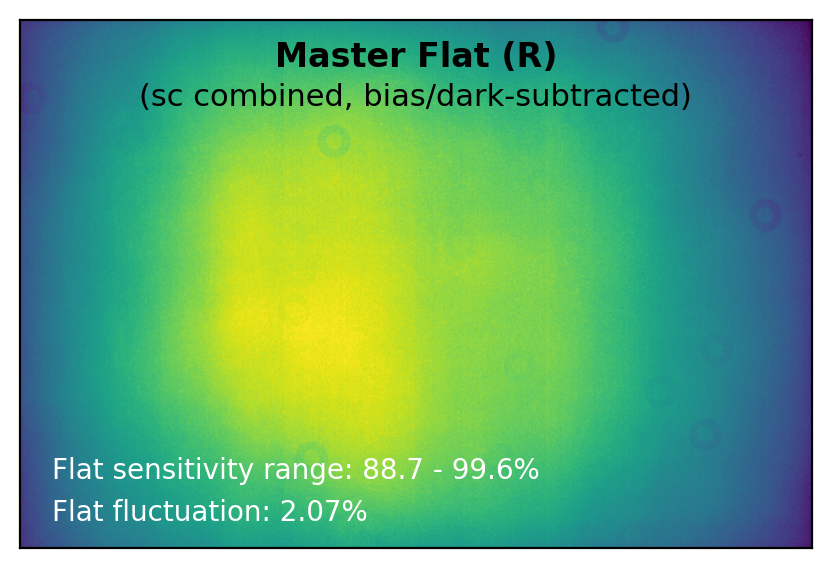

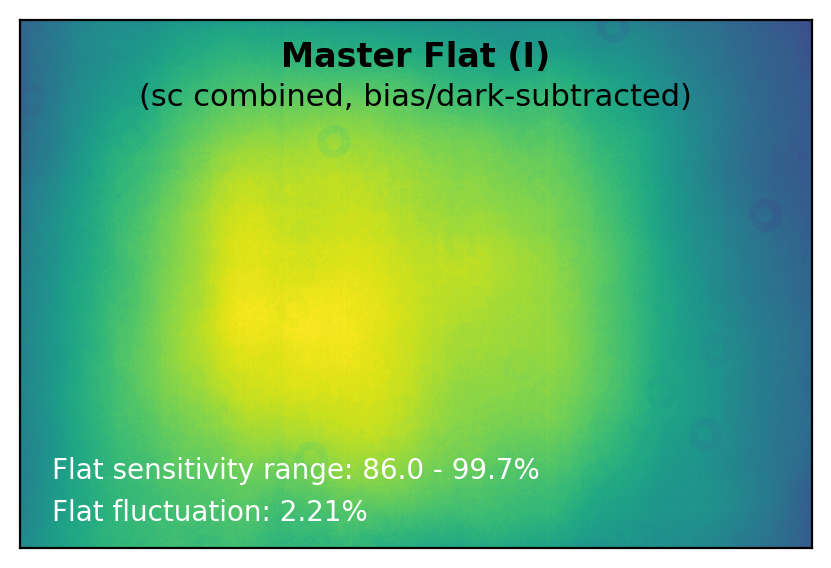

In [11]:
# - combining flat frames for each filter
mflat_list = []      # to save median-combined master flat for each filter
for flat_list in [flat_list_R, flat_list_I]:
    # - checking the basic info : check dates, exposure times, and filters.
    for i in np.arange(len(flat_list)):
        flat_hdr = fits.getheader(flat_list[i])
        print(f"\nFlat frame {i+1:d}")
        for keys in ['DATE-OBS', 'EXPTIME', 'FILTER']:
            print("  "+keys+" = "+str(flat_hdr[keys]))
    
    # - stacking flat frames
    flat_stack = []
    for i in np.arange(len(flat_list)):
        flat_data, flat_hdr = fits.getdata(flat_list[i], header=True)  
        # - bias and dark subtraction
        flat_bd = (flat_data - mbias.data - mdark_flat.data)
        # - flat scaling (with relative sensitivity = 1 at the maximum data point)
        flat_bdn = flat_bd/flat_bd.max()
        flat_stack.append(CCDData(data=flat_bdn, unit='adu'))
    
    # - sigma clipping
    mflat = combine(flat_stack, sigma_clip=True,
                      sigma_clip_low_thresh=3,
                      sigma_clip_high_thresh=3)
    
    # - flat scaling (with relative sensitivity = 1 at the maximum data point)
    # flat_med /= flat_med.max()
    
    # - save the master flat as fits file
    filter_now = flat_hdr['FILTER']     # specifying current filter
    flat_hdr['NFRAMES'] = len(flat_list)
    fits.writeto(OUTDIR/f"MFlat{filter_now}.fits", mflat.data,
                 header=flat_hdr, overwrite=True)
    mflat_list.append(mflat.data)
    
    # - visualization of the master flat
    fig, ax = plt.subplots(1, 1, figsize=(5,3))
    vmin, vmax = interval.get_limits(mflat)
    ax.imshow(mflat, origin='lower', vmin=vmin, vmax=vmax)
    ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
    ax.text(0.50, 0.96, f"Master Flat ({filter_now})", fontsize=12.0,
            fontweight='bold', transform=ax.transAxes, ha='center', va='top')
    ax.text(0.50, 0.88, "(sc combined, bias/dark-subtracted)",
            fontsize=11.0, transform=ax.transAxes, ha='center', va='top')
    ax.text(0.04, 0.12, f"Flat sensitivity range: {100*mflat.data.min():.1f}"
            + f" - {100*mflat.data.max():.1f}%", ha='left', va='bottom',
            fontsize=10.0, color='w', transform=ax.transAxes)
    ax.text(0.04, 0.04, f"Flat fluctuation: {100*np.std(mflat.data):.2f}%",
            fontsize=10.0, color='w', transform=ax.transAxes,
            ha='left', va='bottom')
    plt.tight_layout()
    

# Image preprocessing

In [ ]:
def crrej(data, header, readnoise, method='CR'):
    gain = header['EGAIN'] # e-/ADU electronic gain
    
    # setting kwargs for LACOSMIC
    # two params in LACOSMIC were skipped: gain=2.0, readnoise=6.
    LACOSMIC_KEYS = dict(sigclip=4.5, sigfrac=0.5, objlim=5.0,
                 satlevel=np.inf, niter=4, #pssl=0.0
                 cleantype='medmask', fsmode='median', psfmodel='gauss',
                 psffwhm=2.5, psfsize=7, psfk=None, psfbeta=4.765)
    
    # initialize two CCDData objects
    if method == 'LA':
        ccd_LA = CCDData(data=[0], header=header, unit='adu')
        
        # Following should give identical result to IRAF L.A.Cosmic,
        # "m_LA" is the mask image
        m_LA, ccd_LA.data = astroscrappy.detect_cosmics(
                                data,
                                sepmed=False,  # IRAF LACosmic is sepmed=False
                                gain=gain,
                                readnoise=readnoise,
                                **LACOSMIC_KEYS)
        return ccd_LA, m_LA
    elif method == 'CR':
        ccd_CR = CCDData(data=[0], header=header, unit='adu')
        
        # Following is the "fastest" astroscrappy version. 
        m_CR, ccd_CR.data = astroscrappy.detect_cosmics(
                                data,
                                sepmed=True,
                                gain=gain, 
                                readnoise=readnoise,
                                **LACOSMIC_KEYS)
        return ccd_CR, m_CR
    else:
        raise ValueError('kwarg "method" should be either "LA" or "CR".')
    

def preproc(sci_list, mbias, mdark, mflat, rdnoise, show=True, save=True):
    for i in range(len(sci_list)):
        # bias subtraction, dark subtraction, and flat fielding
        sci_path = sci_list[i]
        sci_data, sci_hdr  = fits.getdata(sci_path, header=True)
        sci_data0 = sci_data.astype('float')    # 'int' type may cause error when calculating
        
        sci_data1 = sci_data0 - mbias    # Bias subtraction
        sci_data1 -= mdark   # Dark subtraction
        sci_data1 /= mflat    # Flat fielding
        
        # cosmic ray rejection
        sci_crrej, sci_mask = crrej(sci_data1, sci_hdr, rdnoise, method='CR')
        
        # visual inspection
        if show:
            fig, axs = plt.subplots(1, 3, figsize=(14,3))
            title = ["Raw Data",
                      "Preprocessed Data",
                      "Cosmic Ray Rejeccted Data"]
            for i, sci_data in enumerate([sci_data0, sci_data1, sci_crrej]):
                ax = axs[i]
                vmin, vmax = interval.get_limits(sci_data)
                ax.imshow(sci_data, cmap='viridis',
                          origin='lower', vmin=vmin, vmax=vmax)
                ax.tick_params(axis='both', length=0.0,
                               labelleft=False, labelbottom=False)
                if i == 0:
                    ax.text(0.04, 0.04, sci_path.name, fontsize=12.0, 
                            transform=ax.transAxes, ha='left', va='bottom')
                ax.text(0.50, 0.96, title[i], fontsize=12.0, fontweight='bold',
                        transform=ax.transAxes, ha='center', va='top')
            plt.tight_layout()
        
        # recording preprocessing history
        now = time.strftime("%Y-%m-%d %H:%M:%S (GMT%z)")
        sci_hdr['RDNOISE'] = rdnoise
        sci_hdr['history'] = 'Preprocessed at ' + now
            
        # saving preprocessed image to a fits file
        scihdu = fits.PrimaryHDU(data=sci_crrej, header=sci_hdr)
        mskhdu = fits.ImageHDU(data=sci_mask.astype('int'), name='MASK')
        hdul = fits.HDUList([scihdu, mskhdu])
        hdul.writeto(OUTDIR/('p'+sci_path.name+'s'), overwrite=True)
        print(f'Done: {sci_path.name}')


for sci_list, mflat in zip([sci_list_R, sci_list_I], mflat_list):
    preproc(sci_list, mbias.data, mdark_sci.data, mflat, rdnoise, show=True)
    

Done: A2255-0004R.fit
Done: A2255-0002R.fit
Done: A2255-0003R.fit
Done: A2255-0001R.fit
Done: A2255-0001I.fit
Done: A2255-0003I.fit
Done: A2255-0002I.fit


# 2. Image Alignment

***

In [ ]:
# fetching path list of the preprocessed science frames
sci_list_R  = list(OUTDIR.glob('p' + OBJNAME + '*R.fits'))
sci_list_I  = list(OUTDIR.glob('p' + OBJNAME + '*I.fits'))

# Initial alignment check

In [ ]:
sci_list = sci_list_R  # here I just selected only the I-band images.

# for displaying in zscale
interval = ZScaleInterval()

fig, axs = plt.subplots(1,len(sci_list), figsize=(3*len(sci_list),3))

for i in range(len(sci_list)):
    img = fits.getdata(sci_list[i], ext=0)
    trim = img[760:860, 1063:1163]
    vmin, vmax = interval.get_limits(trim)
    ax = axs[i]
    ax.imshow(trim, origin='lower', vmin=vmin, vmax=vmax)
    if i == 0:
        # find the rough peak coordinate
        xc, yc = np.unravel_index(np.argmax(trim), trim.shape)
    ax.axvline(yc, c='r', ls='--')
    ax.axhline(xc, c='r', ls='--')
    

# Solving registration with astroalign

In [ ]:
# reference image: frame 0
id_ref = 0
dat_ref, hdr_ref = fits.getdata(sci_list[id_ref], header=True, ext=0)
ccd_ref = CCDData(dat_ref, unit='adu')

# Aligning other images with respect to the reference image
start_time = time.time()
aligned_list = []
for i in range(len(sci_list)):
    dat = fits.getdata(sci_list[i], ext=0)
    msk = fits.getdata(sci_list[i], ext=1)
    ccd = CCDData(dat.byteswap().newbyteorder(), unit='adu', mask=msk)
    if (i == id_ref):
        ccd_aligned = ccd
    else:
        dat_aligned, footprint = aa.register(ccd, ccd_ref,
                                             max_control_points=50,
                                             detection_sigma=5, min_area=16,
                                             propagate_mask=True)
        ccd_aligned = CCDData(dat_aligned, unit='adu')
    aligned_list.append(ccd_aligned)
    # fits.writeto(imglist[i].split(".fit")[0]+"_align_auto.fits", dat_aligned, overwrite=True)
end_time = time.time()
print(f"--- {end_time-start_time:.4f} sec were taken for aligning {len(sci_list):d} images ---") 

In [ ]:
fig, axs = plt.subplots(1,len(sci_list), figsize=(3*len(sci_list),3))
for i in range(len(aligned_list)):
    img = aligned_list[i].data
    trim = img[760:860, 1063:1163]
    vmin, vmax = interval.get_limits(trim)
    ax = axs[i]
    ax.imshow(trim, origin='lower', vmin=vmin, vmax=vmax)
    if i == 0:
        xc, yc = np.unravel_index(np.argmax(trim), trim.shape)
    ax.axvline(yc, c='r', ls='--')
    ax.axhline(xc, c='r', ls='--')

In [ ]:
combined = combine(aligned_list, sigma_clip=True,
                   sigma_clip_high_thresh=3, sigma_clip_low_thresh=3)

plt.figure(figsize=(9,6))
vmin, vmax = interval.get_limits(combined.data)
plt.imshow(combined, origin='lower', vmax=vmax, vmin=vmin)

band = hdr_ref['FILTER']
hdr_ref['CFRAMES'] = len(sci_list)
hdr_ref['history'] = f'Combined image of {len(sci_list)} frames'
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
hdr_ref['history'] = f'Combined at {now}'
scihdu = fits.PrimaryHDU(data=combined.data.astype('float32'), header=hdr_ref)
mskhdu = fits.ImageHDU(data=combined.mask.astype('int'), name='MASK')
hdul = fits.HDUList([scihdu, mskhdu])
hdul.writeto(OUTDIR/('c'+OBJNAME+'_'+band+'.fits'), overwrite=True)

# 3. Astrometry

***

https://nova.astrometry.net/upload generates WCS information for a uploaded fits file.

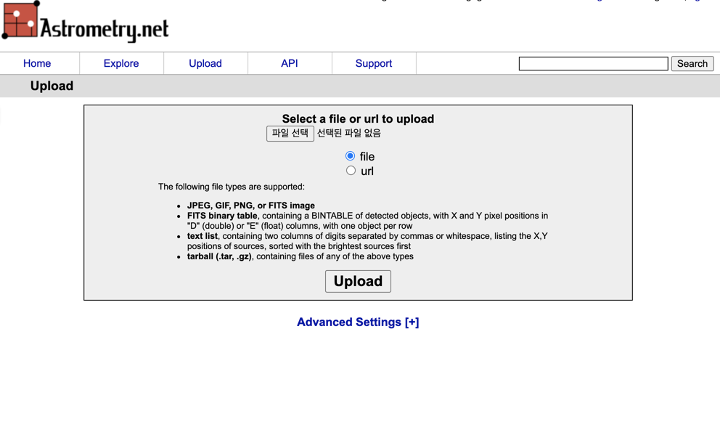